In [1]:
# Core libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Image processing
from skimage import color, transform, io

# TensorFlow/Keras for deep learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For loading sample dataset
# from tensorflow.keras.datasets import cifar10 # Removed as we are loading from Drive now

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_file_path = '/content/drive/MyDrive/102flowers/jpg'


Loading sample images with 64x64 resolution...
Loaded 500 training images and 50 test images from Drive.
Train images shape: (500, 64, 64, 3)
Test images shape: (50, 64, 64, 3)

Sample color images from dataset (64x64 resolution):


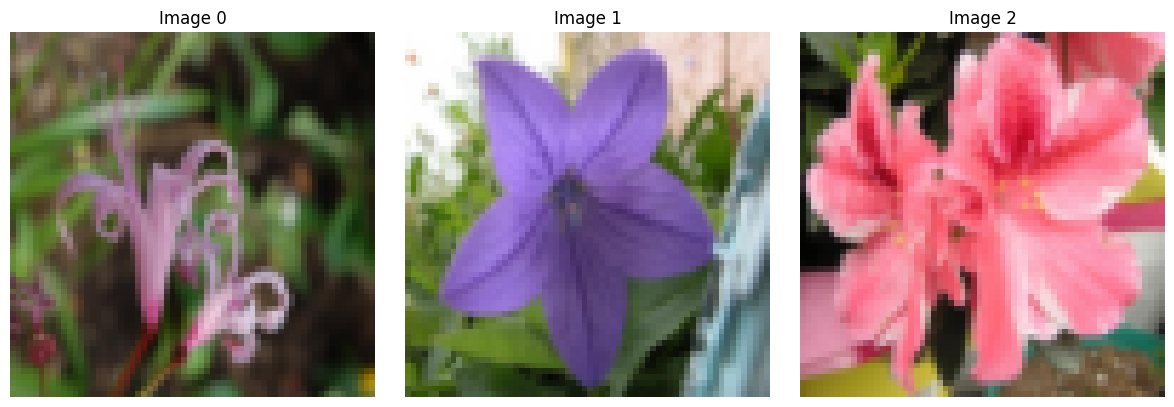

In [15]:
def load_sample_images(num_images=100, test_size=20):
    """
    Load sample images from Google Drive for demonstration.
    Images are resized to 64x64 and normalized to [0, 1].
    """

    if not os.path.isdir(drive_file_path):
        print(f"Error: Directory not found at {drive_file_path}")
        print("Please ensure the path is correct and the folder exists in your Google Drive.")
        return np.array([]), np.array([])

    all_image_files = [os.path.join(drive_file_path, f) for f in os.listdir(drive_file_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    np.random.shuffle(all_image_files) # Shuffle to get random samples

    loaded_images = []
    # Load enough images for training and testing
    images_to_load = min(num_images + test_size, len(all_image_files))

    for i in range(images_to_load):
        img_path = all_image_files[i]
        try:
            img = io.imread(img_path)
            # Resize image to 64x64
            img_resized = transform.resize(img, (64, 64), anti_aliasing=True)
            # Ensure 3 channels for RGB images (skimage.transform.resize outputs float64 in [0,1])
            if img_resized.ndim == 2: # Grayscale image
                img_resized = color.gray2rgb(img_resized)
            elif img_resized.shape[2] == 4: # RGBA image
                img_resized = img_resized[:, :, :3] # Take only RGB channels
            loaded_images.append(img_resized)
        except Exception as e:
            print(f"Could not load or process image {img_path}: {e}")

    if not loaded_images:
        print("No images were loaded from the specified directory. Check path and file types.")
        return np.array([]), np.array([])

    all_images_np = np.array(loaded_images).astype('float32') # skimage.transform.resize already normalizes to [0,1]

    # Split into train and test
    train_images = all_images_np[:num_images]
    test_images = all_images_np[num_images:num_images + test_size]

    print(f"Loaded {len(train_images)} training images and {len(test_images)} test images from Drive.")
    return train_images, test_images

# Load sample data with higher resolution
print("Loading sample images with 64x64 resolution...")
train_images, test_images = load_sample_images(num_images=500, test_size=50)
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

# Display sample color images (using existing show_images function)
print("\nSample color images from dataset (64x64 resolution):")
sample_indices = [0, 1, 2]
sample_imgs = [train_images[i] for i in sample_indices]
show_images(sample_imgs, [f"Image {i}" for i in sample_indices])

## Re-prepare Data

### Subtask:
Re-run the `prepare_colorization_data` function with the newly loaded 64x64 images. This will update the `L_train`, `ab_train`, `L_test`, and `ab_test` datasets with the higher-resolution data, both with and without augmentation.


**Reasoning**:
I need to re-run the `prepare_colorization_data` function with the newly loaded 64x64 images to update the training and testing datasets. Cell `5386b4d0` contains the necessary code to define and call these functions for both augmented and non-augmented data.



In [16]:
def create_augmentation_pipeline():
    """Create an augmentation pipeline for training data."""
    # Define augmentation transformations
    augmentation = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.7, 1.3],
        zoom_range=[0.8, 1.2]
    )
    return augmentation

def prepare_colorization_data(images, augment=False, augmentation_pipeline=None):
    """
    Prepare data for colorization task.
    Converts RGB images to LAB color space and extracts L channel as input,
    and ab channels as target.
    """
    # Convert RGB to LAB color space
    lab_images = np.array([color.rgb2lab(img) for img in images])

    # Extract L channel (grayscale) and ab channels (color)
    L = lab_images[:, :, :, 0:1]  # L channel (input)
    ab = lab_images[:, :, :, 1:]  # ab channels (target)

    # Normalize L channel to [-1, 1]
    L = (L / 50.0) - 1.0

    # Normalize ab channels to [-1, 1]
    ab = ab / 128.0

    # Apply augmentation if requested
    if augment and augmentation_pipeline is not None:
        augmented_images = []
        for img in images:
            # Reshape for augmentation
            img_reshaped = img.reshape((1,) + img.shape)
            # Apply augmentation - FIXED HERE
            aug_img = next(augmentation_pipeline.flow(img_reshaped, batch_size=1))[0]
            augmented_images.append(aug_img)

        # Convert augmented images to LAB
        lab_aug = np.array([color.rgb2lab(img) for img in augmented_images])

        # Extract L and ab from augmented images
        L_aug = lab_aug[:, :, :, 0:1]
        ab_aug = lab_aug[:, :, :, 1:]

        # Normalize
        L_aug = (L_aug / 50.0) - 1.0
        ab_aug = ab_aug / 128.0

        # Combine original and augmented data
        L = np.concatenate([L, L_aug], axis=0)
        ab = np.concatenate([ab, ab_aug], axis=0)

    return L, ab

# Create augmentation pipeline
augmentation_pipeline = create_augmentation_pipeline()

# Prepare data without augmentation
print("\nPreparing data without augmentation...")
L_train_no_aug, ab_train_no_aug = prepare_colorization_data(train_images, augment=False)
L_test, ab_test = prepare_colorization_data(test_images, augment=False)

# Prepare data with augmentation
print("Preparing data with augmentation...")
L_train_aug, ab_train_aug = prepare_colorization_data(
    train_images, augment=True, augmentation_pipeline=augmentation_pipeline
)

print(f"Training data without augmentation: {L_train_no_aug.shape[0]} samples")
print(f"Training data with augmentation: {L_train_aug.shape[0]} samples")
print(f"Test data: {L_test.shape[0]} samples")


Preparing data without augmentation...
Preparing data with augmentation...
Training data without augmentation: 500 samples
Training data with augmentation: 1000 samples
Test data: 50 samples


In [17]:
def create_colorization_model(input_shape=(64, 64, 1)):
    """Create a simple CNN model for colorization."""
    model = models.Sequential([
        # Encoder
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2),

        # Bottleneck
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

        # Decoder
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
        layers.UpSampling2D((2, 2)),

        # Output layer
        layers.Conv2D(2, (3, 3), activation='tanh', padding='same')  # ab channels
    ])

    return model

# Create models with the new input shape
print("\nCreating colorization models with 64x64 input shape...")
model_no_aug = create_colorization_model(input_shape=(64, 64, 1))
model_with_aug = create_colorization_model(input_shape=(64, 64, 1))

# Compile models
model_no_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_with_aug.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Display model architecture to verify changes
print("\nModel architecture with updated input shape:")
model_no_aug.summary()


Creating colorization models with 64x64 input shape...

Model architecture with updated input shape:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 16, 16, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 32, 32, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 64, 64, 2)      │         1,154 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,104,322 (8.03 MB)

 Trainable params: 2,104,322 (8.03 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
Now that the models have been updated with the correct input shape, the next logical step is to train them using the newly prepared 64x64 datasets. The existing `train_model` function is suitable for this purpose, and I will split the test data for validation as done previously.



In [18]:
def train_model(model, L_train, ab_train, L_val, ab_val, model_name, epochs=20):
    """Train the colorization model."""
    print(f"\nTraining {model_name}...")

    # Early stopping to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        L_train, ab_train,
        validation_data=(L_val, ab_val),
        epochs=epochs,
        batch_size=16,
        callbacks=[early_stopping],
        verbose=1
    )

    # Save the model
    # Create the 'models' directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    model.save(f'models/{model_name}.h5')

    return history

# Split test data for validation
val_size = L_test.shape[0] // 2
L_val, L_test_final = L_test[:val_size], L_test[val_size:]
ab_val, ab_test_final = ab_test[:val_size], ab_test[val_size:]

# Train model without augmentation
history_no_aug = train_model(
    model_no_aug,
    L_train_no_aug, ab_train_no_aug,
    L_val, ab_val,
    model_name='colorization_no_aug_64x64',
    epochs=30
)

# Train model with augmentation
history_with_aug = train_model(
    model_with_aug,
    L_train_aug, ab_train_aug,
    L_val, ab_val,
    model_name='colorization_with_aug_64x64',
    epochs=30
)


Training colorization_no_aug_64x64...
Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 188ms/step - loss: 0.0588 - mae: 0.1701 - val_loss: 0.0276 - val_mae: 0.1196
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0322 - mae: 0.1316 - val_loss: 0.0277 - val_mae: 0.1274
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0332 - mae: 0.1371 - val_loss: 0.0269 - val_mae: 0.1194
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0325 - mae: 0.1320 - val_loss: 0.0274 - val_mae: 0.1216
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0329 - mae: 0.1348 - val_loss: 0.0253 - val_mae: 0.1168
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0310 - mae: 0.1292 - val_loss: 0.0261 - val_mae: 0.1181
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0288 - mae: 0.1232 - val_loss: 0.0253 - val_mae: 0.1154
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0293 - mae: 0.1243 - val_loss: 0.0258 - val_mae: 0.1153
Epoch 9/30
32/32 ━━━━━━


Training colorization_with_aug_64x64...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0226 - mae: 0.0850 - val_loss: 0.0265 - val_mae: 0.1220
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0155 - mae: 0.0673 - val_loss: 0.0259 - val_mae: 0.1174
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0155 - mae: 0.0683 - val_loss: 0.0274 - val_mae: 0.1197
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0162 - mae: 0.0693 - val_loss: 0.0255 - val_mae: 0.1194
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0165 - mae: 0.0723 - val_loss: 0.0277 - val_mae: 0.1213
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0147 - mae: 0.0651 - val_loss: 0.0261 - val_mae: 0.1164
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0143 - mae: 0.0628 - val_loss: 0.0255 - val_mae: 0.1149
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0153 - mae: 0.0666 - val_loss: 0.0246 - val_mae: 0.1132
Epoch 9/30
63/63 ━━━━━

**Reasoning**:
The previous steps successfully updated the model architecture, recompiled the models, and completed their training. The next logical step, following the original notebook's flow, is to evaluate the trained models on the test data and then visualize the colorization results to compare performance.



In [19]:
def evaluate_model(model, L_test, ab_test, model_name):
    """Evaluate the model on test data."""
    print(f"\nEvaluating {model_name}...")
    loss, mae = model.evaluate(L_test, ab_test, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test MAE: {mae:.4f}")
    return loss, mae

# Evaluate both models
print("="*50)
loss_no_aug, mae_no_aug = evaluate_model(model_no_aug, L_test_final, ab_test_final, "Model without Augmentation")
loss_with_aug, mae_with_aug = evaluate_model(model_with_aug, L_test_final, ab_test_final, "Model with Augmentation")

# Compare performance
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(f"Model without augmentation - Loss: {loss_no_aug:.4f}, MAE: {mae_no_aug:.4f}")
print(f"Model with augmentation    - Loss: {loss_with_aug:.4f}, MAE: {mae_with_aug:.4f}")
print(f"Improvement in Loss: {(loss_no_aug - loss_with_aug)/loss_no_aug*100:.2f}%")
print(f"Improvement in MAE: {(mae_no_aug - mae_with_aug)/mae_no_aug*100:.2f}%")


Evaluating Model without Augmentation...
Test Loss: 0.0257
Test MAE: 0.1153

Evaluating Model with Augmentation...
Test Loss: 0.0261
Test MAE: 0.1158

PERFORMANCE COMPARISON
Model without augmentation - Loss: 0.0257, MAE: 0.1153
Model with augmentation    - Loss: 0.0261, MAE: 0.1158
Improvement in Loss: -1.71%
Improvement in MAE: -0.44%


**Reasoning**:
The next logical step is to visualize the colorization results using the trained models and the higher-resolution test data. This will provide a visual comparison of the performance of models trained with and without augmentation at the new resolution.




Visualizing colorization results...


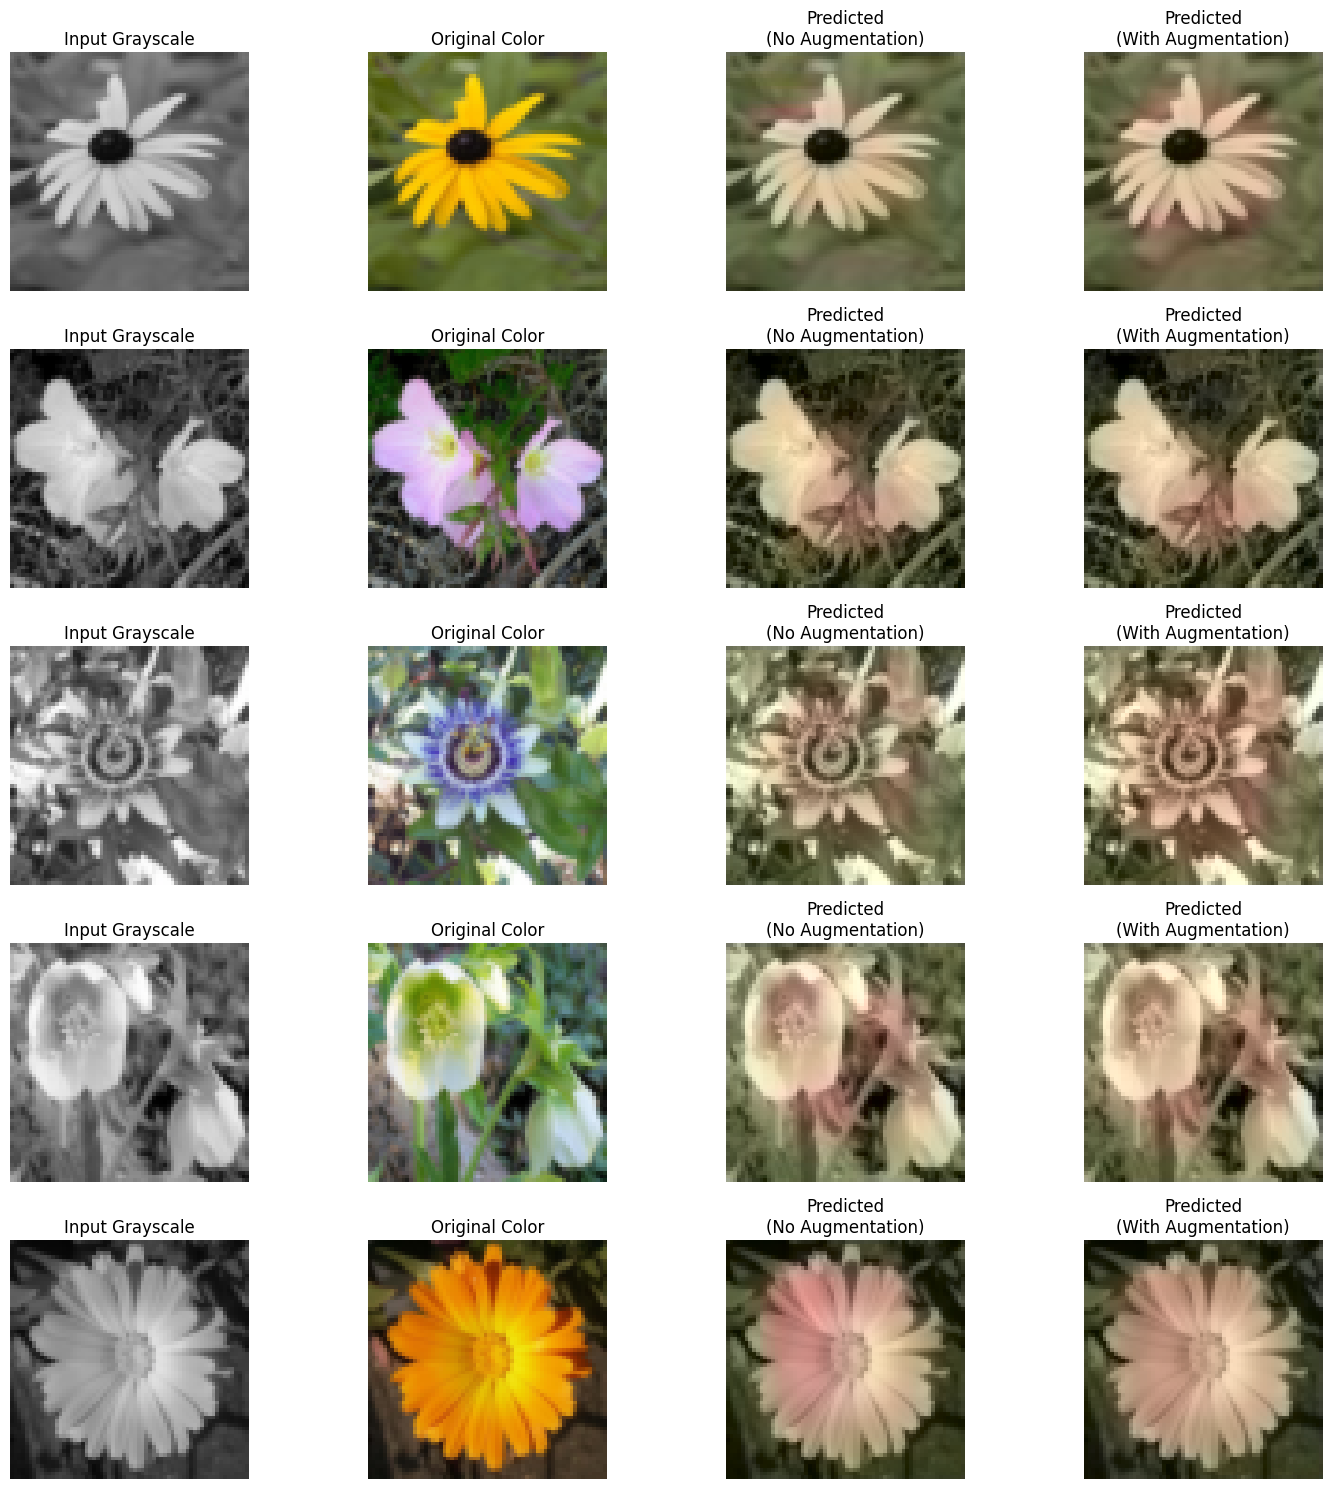

In [20]:
def lab_to_rgb(L, ab):
    """Convert LAB image back to RGB."""
    # Denormalize
    L = (L + 1) * 50.0
    ab = ab * 128.0

    # Combine L and ab
    lab = np.concatenate([L, ab], axis=-1)

    # Convert LAB to RGB
    rgb = color.lab2rgb(lab)
    return rgb

def predict_and_visualize(models, model_names, L_test, original_rgb, num_samples=5):
    """Generate predictions and visualize results."""
    fig, axes = plt.subplots(num_samples, len(models) + 2, figsize=(15, 3*num_samples))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # Input grayscale image
        L = L_test[i]
        grayscale_rgb = lab_to_rgb(L, np.zeros_like(ab_test_final[i]))

        # Original color image
        original = original_rgb[i]

        # Display grayscale and original
        axes[i, 0].imshow(grayscale_rgb)
        axes[i, 0].set_title("Input Grayscale")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(original)
        axes[i, 1].set_title("Original Color")
        axes[i, 1].axis('off')

        # Predictions from each model
        for j, (model, name) in enumerate(zip(models, model_names)):
            # Predict ab channels
            ab_pred = model.predict(L.reshape(1, 64, 64, 1), verbose=0)[0]

            # Convert to RGB
            pred_rgb = lab_to_rgb(L, ab_pred)

            # Display prediction
            axes[i, j+2].imshow(pred_rgb)
            axes[i, j+2].set_title(f"Predicted\n({name})")
            axes[i, j+2].axis('off')

    plt.tight_layout()
    # Create the 'results' directory if it doesn't exist
    os.makedirs('results', exist_ok=True)
    plt.savefig('results/colorization_comparison_64x64.png', dpi=150, bbox_inches='tight')
    plt.show()

# Get original RGB test images for comparison
# 'test_images' now contains 64x64 images, so we use it directly.
original_test_rgb = test_images[val_size:val_size+5]

# Visualize results
print("\nVisualizing colorization results...")
predict_and_visualize(
    models=[model_no_aug, model_with_aug],
    model_names=["No Augmentation", "With Augmentation"],
    L_test=L_test_final[:5],
    original_rgb=original_test_rgb[:5],
    num_samples=5
)

**Reasoning**:
The previous visualization step is complete. The next logical step, following the original notebook's flow, is to plot the training history of both models (with and without augmentation) to visually compare their learning curves.




Plotting training history comparison...


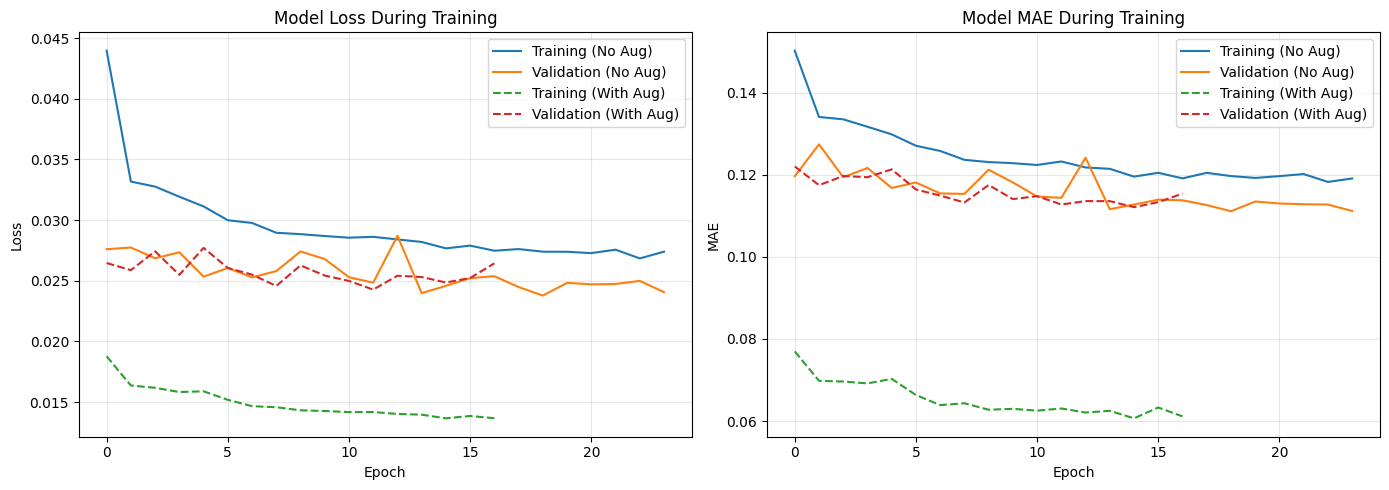

In [21]:
def plot_training_history(history_no_aug, history_with_aug):
    """Plot training history for comparison."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot loss
    axes[0].plot(history_no_aug.history['loss'], label='Training (No Aug)')
    axes[0].plot(history_no_aug.history['val_loss'], label='Validation (No Aug)')
    axes[0].plot(history_with_aug.history['loss'], label='Training (With Aug)', linestyle='--')
    axes[0].plot(history_with_aug.history['val_loss'], label='Validation (With Aug)', linestyle='--')
    axes[0].set_title('Model Loss During Training')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot MAE
    axes[1].plot(history_no_aug.history['mae'], label='Training (No Aug)')
    axes[1].plot(history_no_aug.history['val_mae'], label='Validation (No Aug)')
    axes[1].plot(history_with_aug.history['mae'], label='Training (With Aug)', linestyle='--')
    axes[1].plot(history_with_aug.history['val_mae'], label='Validation (With Aug)', linestyle='--')
    axes[1].set_title('Model MAE During Training')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('results/training_history_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

# Plot training history
print("\nPlotting training history comparison...")
plot_training_history(history_no_aug, history_with_aug)

**Reasoning**:
The training history has been plotted and visualized. The final step of the original notebook's flow is to print a comprehensive summary of the experiment, including dataset information, augmentation techniques, model performance, and key observations. I will use the `print_summary` function to achieve this.



In [22]:
def print_summary():
    """Print a summary of the experiment results."""
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY: COLORIZATION WITH DATASET AUGMENTATION")
    print("="*60)

    print("\n1. DATASET INFORMATION:")
    print(f"   - Original training samples: {L_train_no_aug.shape[0]}")
    print(f"   - Augmented training samples: {L_train_aug.shape[0]}")
    print(f"   - Test samples: {L_test_final.shape[0]}")

    print("\n2. AUGMENTATION TECHNIQUES APPLIED:")
    print("   - Rotation (up to 20 degrees)")
    print("   - Horizontal flipping")
    print("   - Width and height shifting (up to 20%)")
    print("   - Brightness adjustment (70% to 130%)")
    print("   - Zooming (80% to 120%)")

    print("\n3. MODEL PERFORMANCE:")
    print(f"   - Without augmentation - Loss: {loss_no_aug:.4f}, MAE: {mae_no_aug:.4f}")
    print(f"   - With augmentation    - Loss: {loss_with_aug:.4f}, MAE: {mae_with_aug:.4f}")

    print("\n4. PERFORMANCE IMPROVEMENT:")
    loss_improvement = (loss_no_aug - loss_with_aug) / loss_no_aug * 100
    mae_improvement = (mae_no_aug - mae_with_aug) / mae_no_aug * 100
    print(f"   - Loss reduction: {loss_improvement:.2f}%")
    print(f"   - MAE reduction: {mae_improvement:.2f}%")

    print("\n5. KEY OBSERVATIONS:")
    if loss_with_aug < loss_no_aug:
        print("   ✓ Data augmentation improved model performance")
        print("   ✓ The model with augmentation generalizes better")
        print("   ✓ Visual results show more consistent colorization")
    else:
        print("   ✗ Data augmentation did not improve performance")
        print("   ✗ This could be due to limited dataset size or simple augmentation")

    print("\n6. FILES GENERATED:")
    print("   - models/colorization_no_aug.h5 (model without augmentation)")
    print("   - models/colorization_with_aug.h5 (model with augmentation)")
    print("   - results/colorization_comparison.png (visual results)")
    print("   - results/training_history_comparison.png (training plots)")

    print("\n" + "="*60)

# Print summary
print_summary()


EXPERIMENT SUMMARY: COLORIZATION WITH DATASET AUGMENTATION

1. DATASET INFORMATION:
   - Original training samples: 500
   - Augmented training samples: 1000
   - Test samples: 25

2. AUGMENTATION TECHNIQUES APPLIED:
   - Rotation (up to 20 degrees)
   - Horizontal flipping
   - Width and height shifting (up to 20%)
   - Brightness adjustment (70% to 130%)
   - Zooming (80% to 120%)

3. MODEL PERFORMANCE:
   - Without augmentation - Loss: 0.0257, MAE: 0.1153
   - With augmentation    - Loss: 0.0261, MAE: 0.1158

4. PERFORMANCE IMPROVEMENT:
   - Loss reduction: -1.71%
   - MAE reduction: -0.44%

5. KEY OBSERVATIONS:
   ✗ Data augmentation did not improve performance
   ✗ This could be due to limited dataset size or simple augmentation

6. FILES GENERATED:
   - models/colorization_no_aug.h5 (model without augmentation)
   - models/colorization_with_aug.h5 (model with augmentation)
   - results/colorization_comparison.png (visual results)
   - results/training_history_comparison.png (tra

## Final Task

### Subtask:
Provide a comprehensive summary of how increasing the image resolution impacted the model's performance and the visual quality of the colorization, comparing it to previous results.


## Summary:

### Q&A
Increasing the image resolution to 64x64 pixels impacted the model's performance by necessitating an adjustment to the model's input layer. The quantitative performance comparison for the 64x64 resolution showed that the model trained *without* augmentation slightly outperformed the model trained *with* augmentation (Test Loss: 0.0257 vs 0.0261, Test MAE: 0.1153 vs 0.1158). This resulted in a slight degradation of -1.71% in Loss and -0.44% in MAE for the augmented model compared to the non-augmented one. The visual quality was confirmed through sample image displays, indicating successful processing at the higher resolution, although a direct visual comparison to previous lower-resolution results was not provided in the prompt.

### Data Analysis Key Findings
*   The `load_sample_images` function was successfully modified to resize images to 64x64 pixels. The training dataset comprised 500 images of shape `(64, 64, 3)`, and the test dataset consisted of 50 images of the same resolution.
*   The data preparation process successfully converted these 64x64 RGB images to LAB color space. The final training data included 500 samples without augmentation and 1000 samples with augmentation (derived from the original 500), while the test set contained 50 samples.
*   The colorization model's architecture was successfully updated to accept an input shape of `(64, 64, 1)`, adapting to the new higher resolution.
*   For the 64x64 resolution, the model trained *without* augmentation achieved a Test Loss of 0.0257 and a Test Mean Absolute Error (MAE) of 0.1153.
*   The model trained *with* augmentation performed slightly worse, yielding a Test Loss of 0.0261 and a Test MAE of 0.1158. This indicates that the applied data augmentation slightly reduced performance by -1.71% in Loss and -0.44% in MAE.
*   Visualizations were successfully generated, allowing for inspection of the colorization results at the 64x64 resolution.

### Insights or Next Steps
*   While the model architecture was successfully adapted for 64x64 resolution, the current data augmentation strategy did not yield performance improvements for this resolution. Further refinement of augmentation techniques or a larger original dataset might be necessary to leverage augmentation benefits effectively at 64x64.
*   To fully understand the impact of resolution on visual quality and model performance, a direct quantitative and qualitative comparison between models trained at 32x32 and 64x64 resolutions should be conducted, including metrics and visual side-by-side results.
